# Исследование поведения доноров

[DonorSearch](https://donorsearch.org/about/) мотивирует людей становиться донорами. Главная цель проекта - увеличить количество доноров. Вовлекать больше существующих доноров.

Были выделены следующие вопросы:
- Составить портрет донора, сегментировать доноров.
- Как привлекать больше пользователей?
- Как вовлекать существующих пользователей?

Найти аномалии, интересные закономерности в данных.

### Скачивание и настройка окружения

In [ ]:
from google.colab import drive
drive.mount('/content/donor_search')

Drive already mounted at /content/donor_search; to attempt to forcibly remount, call drive.mount("/content/donor_search", force_remount=True).


In [ ]:
!pip install folium

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import transforms
import folium
import requests
import re
import datetime
import numpy as np

In [ ]:
# install chromium, its driver, and selenium
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
# set options to be headless, ..
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
# open it, go to a website, and get results
driver = webdriver.Chrome('chromedriver',options=options)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (91.0.4472.101-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


### Вспомогательные функции

In [ ]:
def primary_analyze(df):
    """
    Первичный анализ датафрейма

    df - рассматриваемый датафрейм
    """
    df.info()
    print(f'Количество дубликатов = {sum(df.duplicated())}')
    #display(df.head())

In [ ]:
def skew_check(df1, df2, check_column, deviation_limit, suffixes_):
  """
  Проверяет отсутствие перекоса в двух датафреймах в заданном столбце.

  df1 - первый датафрейм для сравнения 
  df2 - второй датафрейм для сравнения 
  check_column - проверяемый столбец
  deviation_limit - отклонение в двух группах, считаемое допустимым 
  suffixes_ - суффиксы к столбцу сравнения
  """
  
  # Формирования относительного разделения по значениям столбца
  df1_rel = (round(df1[check_column].value_counts() / len(df1), 2)).reset_index()
  df2_rel = (round(df2[check_column].value_counts() / len(df2), 2)).reset_index()
  
  df_aggregate = df1_rel.merge(df2_rel, how='outer', on='index',
                                  suffixes=(suffixes_[0], suffixes_[1]))
  
  # Сравнение разницы частей в двух группах 
  df_aggregate['compare_parts'] = abs(df_aggregate[f'{check_column}{suffixes_[0]}']
                                  - df_aggregate[f'{check_column}{suffixes_[1]}'])
  
  return df_aggregate.query('compare_parts > @deviation_limit')\
  [['index', f'{check_column}{suffixes_[0]}', f'{check_column}{suffixes_[1]}']]

In [ ]:
def distribution_donation_in_time(df, time_interval, title):
    """
    Построение гистограмм числа донаций по временным промежуткам

    df - датасет
    time_interval - рассматриваемый интервал
    title - название временного интервала для заголовка
    """
    col_ag = df.columns[1]
    index_pronoun = 'этот'
    if time_interval == 'регион':
        index_pronoun = 'этом'
    fig = px.bar(df, x = "index", y = col_ag,
                   color_discrete_sequence=['cornflowerblue'], width=650, height=450)
    fig.update_layout(title = f"Распределение числа донаций по {title}",
                  xaxis_title = f"{time_interval.capitalize()}",
                  yaxis_title = f"Число людей совершивших донацию в {index_pronoun} {time_interval}")
    fig.update_traces(texttemplate='%{y:.3}', textposition='outside', hoverinfo = "all", 
                hovertemplate = time_interval.capitalize() + " донации: %{x}<br>Число людей совершивших донацию в " + index_pronoun
                      + time_interval + ": %{y}")

    fig.show()

In [ ]:
def get_geo_info_about_homes(array_addresses, api_key='c83d11b5-7906-4d02-a13b-ef304960c16e'):
    '''
    Получение координат при помощи API Yandex.Геокодер по адресам

    array_addresses - список адресов
    api_key - ключ для доступа к апи
    '''
    adress_list = []

    # Перебор всех адресов и получение координат по адресу 
    for address in array_addresses:
        try:

            URL_for_request = 'https://geocode-maps.yandex.ru/1.x/?apikey={}&geocode='.format(api_key) + address
            
            data_for_request = requests.get(URL_for_request).text           
            result_requests = re.search('<pos>(.*?)<', data_for_request).group(1)
            adress_list.append(result_requests)
        except:
            adress_list.append('invalid geo')
            print(address)

    return adress_list

# Обзор даннных


## donations_df

### Активность доноров

In [ ]:
donations_df = pd.read_csv('donor_search/MyDrive/donor_search/donations_anon.csv')
primary_analyze(donations_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97874 entries, 0 to 97873
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       97874 non-null  int64 
 1   ID пользователя          97874 non-null  int64 
 2   Класс крови              97874 non-null  object
 3   Дата донации             97874 non-null  object
 4   Дата добавления донации  97874 non-null  object
 5   Тип донации              97874 non-null  object
 6   Регион                   97874 non-null  object
 7   Место стадчи             97874 non-null  object
 8   Статус донации           97874 non-null  object
 9   Есть справка             97874 non-null  object
dtypes: int64(2), object(8)
memory usage: 7.5+ MB
Количество дубликатов = 0


In [ ]:
donations_df = donations_df.rename(columns={'ID': 'id_donation', 'ID пользователя': 'id_user', 'Класс крови': 'class_blood',
                            'Дата донации': 'date_donation', 'Дата добавления донации': 'date_add_donation',
                            'Тип донации': 'type_donation', 'Регион': 'region', 'Место стадчи': 'place_donation',
                            'Статус донации': 'status', 'Есть справка': 'certificate'})

Дубликатов, пропусков не обнаружено. Для удобства в будущем переименуем столбцы. Исследуем данные в отдельных столбцах.

In [ ]:
fig = px.histogram(donations_df['id_user'].value_counts().reset_index(), x="id_user",
                   color_discrete_sequence=['cornflowerblue'])
fig.update_layout(title="Распределение людей по количеству донаций",
                  xaxis_title="Количество донаций",
                  yaxis_title="Число людей совершивших донацию столько раз")
fig.update_traces(hoverinfo="all", hovertemplate="Количество донаций: %{x}<br>Число людей совершивших донацию столько раз: %{y}")
fig.show();

In [ ]:
who_how_many_df = donations_df['id_user'].value_counts().reset_index()['id_user'].value_counts().reset_index().sort_values('index')
who_how_many_df = who_how_many_df.rename(columns={'index': 'count_donations', 'id_user': 'count_peoples'})

count_peoples = list(who_how_many_df['count_peoples'])
count_peoples.insert(0, 0)
who_how_many_df['previous_count'] = count_peoples[:-1]

who_how_many_df['prcnt_churn'] = round(100 * (who_how_many_df['previous_count'] - who_how_many_df['count_peoples']) / who_how_many_df['previous_count'], 2)

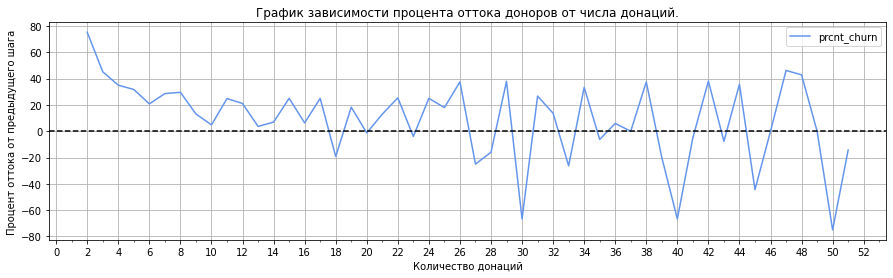

In [ ]:
ax = who_how_many_df.query('count_donations != 1.0 and count_donations < 52').\
        plot(x='count_donations',y='prcnt_churn', grid=True, figsize=(15,4), color = 'cornflowerblue')
plt.title("График зависимости процента оттока доноров от числа донаций.")
plt.xlabel("Количество донаций")
plt.axhline(y=0, color='black', linestyle='--') 
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.ylabel("Процент оттока от предыдущего шага");

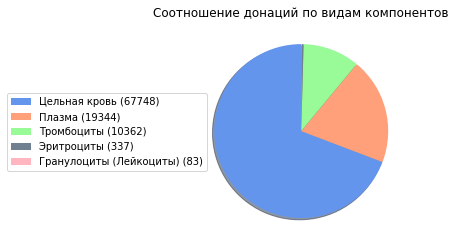

In [ ]:
colors_set_pie = ['cornflowerblue', 'lightsalmon', 'palegreen', 'slategrey', 'lightpink']
types_blood = donations_df['class_blood'].value_counts().reset_index()
figure, ax = plt.subplots()
ax.pie(types_blood['class_blood'], colors = colors_set_pie, shadow=True, startangle=90)
plt.title('Соотношение донаций по видам компонентов')
labels = [f"{n} ({v})" for n,v in zip(types_blood['index'], types_blood['class_blood'])]
plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'best', labels = labels)

plt.show();

#### Наблюдения:
* Наиболее часто люди совершают донацию единожды;
* Лишь 25% совершивших первую донацию приходят на вторую;
* Число людей совершающих всё больше донаций постоянно уменьшается;
* Процент ушедших относительно от шага к шагу крайне нестабилен;
* Подозрительно, что именно на числе донаций кратных 10 большое число людей переставших совершать донации;
* Подавляющее число людей сдаёт именно цельную кровь.

#### Гипотезы:
* Первый опыт донации по какой-то причине оставляет негативный осадок;
* При числе донаций более 25 люди "добивают" число до каких-то круглых значений;
* При потребности в отдельных компонентах стоит акцентировать внимание на этом, возможное незнание людей может являться причиной количества сдач.

### Распределение донаций во времени

In [ ]:
donations_df['year'] = donations_df['date_donation'].str[-4:]
donations_df = donations_df.loc[donations_df['year'].str[0] != '.']
donations_df['year'] = donations_df['year'].astype(int)
donations_df = donations_df.query('year > 1970 and year <= 2021')

donations_df['date_add_donation'] = pd.to_datetime(donations_df['date_add_donation'])
donations_df['date_donation'] = pd.to_datetime(donations_df['date_donation'])

In [ ]:
donations_df['dow'] = donations_df['date_donation'].dt.day_name()
distribution_donation_in_time(donations_df['dow'].value_counts().reset_index(), 'день недели', 'дням недели')

In [ ]:
donations_df['dom'] = donations_df['date_donation'].dt.month_name()
donations_df['month_year'] = donations_df['date_donation'].dt.to_period('M')

distribution_donation_in_time(donations_df['dom'].value_counts().reset_index(), 'месяц', 'месяцу')

In [ ]:
test_df = donations_df.query('year > 2012').groupby(['month_year'])['id_donation'].nunique().reset_index()
test_df['month_year'] = test_df['month_year'].astype('str')
test_df['year'] = test_df['month_year'].str[:4]

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = go.Figure()

for year in test_df['year'].unique():
    fig.add_trace(go.Bar(
    x = months,
    y = test_df.query(f'year == "{year}"')['id_donation'].values,
    name=year,
    ))

fig.update_layout(title = "Распределение числа донаций по месяцам и годам",
                  xaxis_title = "Месяц донации",
                  yaxis_title = "Число донаций в заданный год и месяц")
fig.update_traces(hoverinfo = "all", 
                hovertemplate = "%{y} людей совершило донацию в месяц %{x} и год")
fig.show();

In [ ]:
distribution_donation_in_time(donations_df.query('year > 2000')['year'].value_counts().reset_index(),
                              'год', 'годам')

#### Наблюдения:
* Число донаций в будни существенно больше;
* Начиная с 2015 года наблюдается убывающий тренд числа донаций, из-за сбоя базы в феврале 2020, данные с 2018 по 2020 вероятно иные, но тренд начался раньше;
* Активность доноров в разные месяцы неоднородна. 


#### Предположения:
- Люди пользуются выходным после кроводачи, то после сдачи в четверг у человека получается длинные выходные, что логично. 
- Но на основе собственных донаций кажется, что в выходные кроводач сильно больше, особенно в воскресенье, + на основе загруженности записей в spkdzm, в связи с чем кажется странным распределение по дням.
- Это говорит о людях, пользующихся DonorSearch, мотивация этих людей спасение жизней, получение определенного признания.

### Распределение донаций по вознаграждению

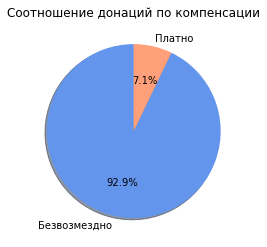

In [ ]:
donation_by_payments = donations_df['type_donation'].value_counts().reset_index()

plt.pie(donation_by_payments['type_donation'], colors = ['cornflowerblue', 'lightsalmon'], shadow=True,
        startangle=90, labels=donation_by_payments['index'], autopct='%1.1f%%')
plt.title('Соотношение донаций по компенсации');

#### Выводы:

* Замечательное соотношение, Руслан акцентировал внимание на важности именно безвозмездных доноров;
* Однако потребности и жизненные ситуации у людей различны и например студенты, могли бы значительно увеличить число доноров, при этом возможно формирование у них привычки и переход в разряд безвозмездных доноров;
* При донации в первую волну covid'a удивил как никогда много людей.

### Распределение донаций по регионам

In [ ]:
def region_by_place(df):
    '''
    Замена по пунктам сдачи крови регионов

    df - датасет 
    '''
    place_numbers = donations_df.query('region != "Не указано" and place_donation != "Выездная акция"'). \
                groupby('place_donation')['region'].max().reset_index()
    places_by_numbers_dict = dict(zip(place_numbers['place_donation'], place_numbers['region']))
    
    def replace_func(row):
        '''
        Замена пропусков

        row - строка
        '''

        if row['place_donation'] in places_by_numbers_dict:
            return places_by_numbers_dict[row['place_donation']]
        
        return 'Не указано'

    df['region'] = df.apply(replace_func, axis = 1)


region_by_place(donations_df)

In [ ]:
distribution_donation_in_time(donations_df['region'].value_counts().sort_values(ascending = False).head(10).reset_index(),
                              'регион', 'регионам')

In [ ]:
donations_wth_reg = donations_df.query('region == "Не указано"')

print('{:.2%} пропусков регионов, которые происходили на выездных акциях'
    .format(len(donations_wth_reg.query('place_donation == "Выездная акция"')) / len(donations_wth_reg)))

51.35% пропусков регионов, которые происходили на выездных акциях


In [ ]:
count_by_type_donation = donations_df.query('region == "Россия, Москва"')\
            ['type_donation'].value_counts()

print('{:.2%} платных донаций в Москве'
      .format(count_by_type_donation['Платно'] / sum(count_by_type_donation)))

8.31% платных донаций в Москве


In [ ]:
donations_df['place_donation'].value_counts() / len(donations_df)

Выездная акция    0.091736
633               0.061672
176               0.025597
641               0.021293
619               0.018237
                    ...   
159               0.000010
468               0.000010
804               0.000010
169               0.000010
29                0.000010
Name: place_donation, Length: 776, dtype: float64

#### Выявление самых многосдающих городов

In [ ]:
# Выделение из списков всех субъектов именно городов
population_by_city_df = pd.read_csv('donor_search/MyDrive/donor_search/data_population.csv')
population_by_city_df = population_by_city_df.query('type == "г"')

# Подсчет суммарного числа жителей в городе, а не районе
population_by_city_df['population'] = population_by_city_df['population'].astype('int')
population_by_city_df = population_by_city_df.groupby('settlement')['population'].sum().reset_index()

In [ ]:
donations_df['city'] = donations_df['region'].apply(lambda x: x.split()[-1])
statistics_by_city = donations_df.groupby('city'). \
                agg({'id_user':pd.Series.nunique, 'id_donation':pd.Series.nunique}).reset_index()

statistics_by_city = statistics_by_city. \
        rename(columns={'id_user': 'count_donors', 'id_donation': 'count_donations'})

statistics_by_city = statistics_by_city.merge(population_by_city_df,
                how='inner', left_on='city', right_on = 'settlement')

In [ ]:
statistics_by_city['donations_per_1000'] = round(statistics_by_city['count_donations'] * 1000 
                                            / statistics_by_city['population'], 2)
statistics_by_city['donors_per_1000'] = round(statistics_by_city['count_donors'] * 1000
                                            / statistics_by_city['population'], 2)
abnormal_cities_donations = statistics_by_city. \
                    sort_values('donations_per_1000', ascending = False).head(7).loc[:, 'city'].values

statistics_by_city.sort_values('donors_per_1000', ascending = False).head(5).drop('settlement', axis = 1)

,city,count_donors,count_donations,population,donations_per_1000,donors_per_1000
71,Краснокамск,386,1748,53864,32.45,7.17
44,Донецк,65,441,48428,9.11,1.34
1,Альметьевск,148,468,151157,3.10,0.98
65,Клин,70,360,80585,4.47,0.87
54,Казань,1039,3680,1205651,3.05,0.86


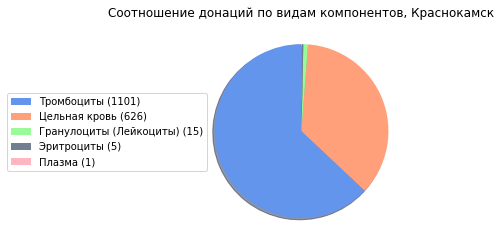

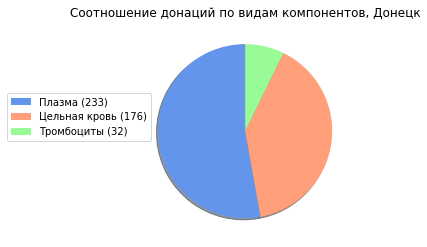

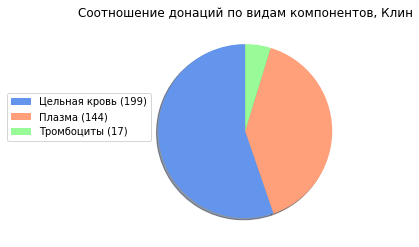

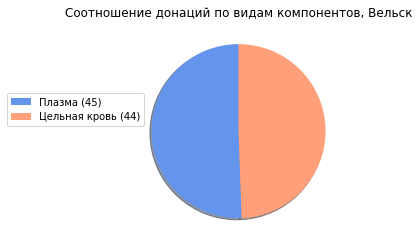

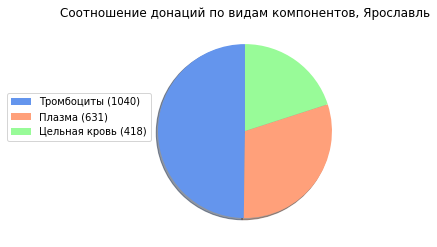

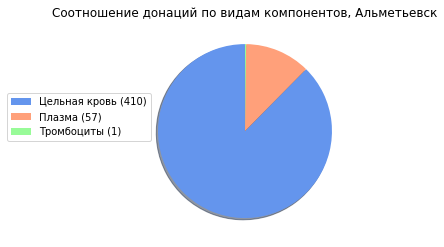

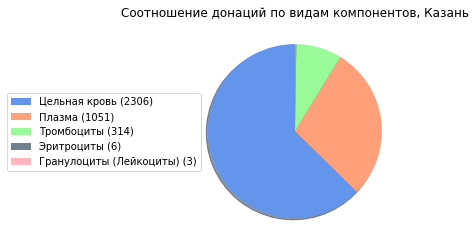

In [ ]:
colors_set_pie = ['cornflowerblue', 'lightsalmon', 'palegreen', 'slategrey', 'lightpink']

for city in abnormal_cities_donations:
    types_blood = donations_df.query(f'city == "{city}"')['class_blood'].value_counts().reset_index()
    figure, ax = plt.subplots()
    ax.pie(types_blood['class_blood'], colors = colors_set_pie, shadow=True, startangle=90)
    plt.title(f'Соотношение донаций по видам компонентов, {city}')
    labels = [f"{n} ({v})" for n,v in zip(types_blood['index'], types_blood['class_blood'])]
    plt.legend(
        bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
        loc = 'best', labels = labels)

    plt.show();

#### Выводы:

- Люди предпочитают сдавать кровь в пунктах, а не на выездных акциях, на них было совершено 9.1% от общего числа донаций.


В аномально часто сдающих городах были замечены следующие отклонения:
* Распределение донаций компонентов крови в Краснокамске, Донецке, Клине, Вельске, Ярославле далеко от среднего распределения по всем данным;
* Имеются какие-то ошибки с идентификаторами мест сдачи:
    * 311 - на основе сайта имеет адрес "Орёл, Наугорское шоссе, д. 2", но доноры из "Россия, Московская область, Клин", между этими точками 470 км, это кажется подозрительным;
    * 656 - на основе сайта имеет адрес "Москва, ул. Саморы Машела, дом 1", но доноры из "Россия, Пермский край, Краснокамск", между этими точками - 1400 км, что также странно.

Отдельно по городам:

* Казань - Родина и место жительство с 2001 года Руслана, в связи с чем ожидаемо, что там много знают об этом проекте;
* Альметьевск в той же республике, довольно близок к Казане, является адмиинстративным центром республике;
* Донецк - усложнилась ситуация в регионе в связи с чем рост желаний сдать кровь и числа зарегистрированных логичен;
* Клин - подозрительный город, скорее всего по какой-то ошибке 311 пункт добавился к ним, или же были выездные донации от этого центра крови;
* Краснокамск - удивительный город, скорее всего случилась ошибка, в городе пунктов сдачи крови нет, 656 - находится в Москве, требует рассмотрения.

### Выявление пунктов, в которых не отмечают регион 

In [ ]:
centers_wth_region = donations_df.query('region == "Не указано"')['place_donation'].unique()

In [ ]:
adresses_centers = []
for center in centers_wth_region[1:]:
    driver.get(f'https://donorsearch.org/bloodstations/{center}/')
    try:
        current_address = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "detailBloodStationInfo_DetailBloodStationInfo_Body_Left__2FxAo"))
        )
        adresses_centers.append(current_address.text.split('\n')[0])
    except:
        print(f'Проблема в центре {center}')


Проблема в центре 1067
Проблема в центре 1066


In [ ]:
geo_pos_centers = get_geo_info_about_homes(adresses_centers)

In [ ]:
map = folium.Map(location=[60.9, 100.05], zoom_start=3)
for point in range(0, len(adresses_centers)):
    folium.Marker(geo_pos_centers[point].split()[::-1], popup=adresses_centers[point]).add_to(map)

map

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_51f2416ec93b455ab8b2fc6472b383b9%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_51f2416ec93b455ab8b2fc6472b383b9%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_51f2416ec93b455ab8b2fc6472b383b9%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_51f2416ec93b455ab8b2fc6472b383b9%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B60.9%2C%20100.05%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20crs%3A%20L.CRS.EPSG3857%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoom%3A%203%2C%0A%20%20%20%20%20%20%20%20

#### Выводы:
* Очень странно, что в большей половине всех пунктов кроводачи не оставляют регион.
* Полагаю, что эта информация может быть важна будущим рекламодателям, в связи с чем вынес на карту все такие пункты, возможно Руслан знает чем они отличаются или же возможно заполнить пропуски исходя из имеющейся информации.
* Найдено 2 пункта, о которых нет информации на сайте, но они числятся, как возможные для сдачи, необходимо понять, чем они отличаются от других, номера 1067, 1066.

### Разница в днях между донациями

In [ ]:
user_date_donation = donations_df[['id_user', 'date_donation']]
donors_donation = user_date_donation.groupby('id_user')['date_donation'].min().reset_index()
user_date_donation = pd.concat([user_date_donation, 
                                donors_donation]).drop_duplicates(keep=False)

counter_donations = 1

while not user_date_donation.empty:
    current_donations = user_date_donation.groupby('id_user')['date_donation'].min().reset_index()
    counter_donations += 1
    donors_donation = donors_donation.merge(current_donations, how='outer', on='id_user', suffixes=['', f'_{counter_donations}'])
    user_date_donation = pd.concat([user_date_donation, 
                                current_donations]).drop_duplicates(keep=False)

In [ ]:
interval_between_donation = (donors_donation['date_donation_2'] - donors_donation['date_donation']).value_counts().to_frame()

for counter_donation in range(3, len(donors_donation.columns)-1):
    current_donation = (donors_donation[f'date_donation_{counter_donation}']
                    - donors_donation[f'date_donation_{counter_donation - 1}']).value_counts().to_frame()
    
    interval_between_donation = interval_between_donation.add(current_donation). \
    combine_first(interval_between_donation).combine_first(current_donation)

In [ ]:
interval_between_donation.sort_values(by = 0, ascending = False).astype('int').head(10)

,0
63 days,1880
14 days,1276
28 days,1070
62 days,953
15 days,893
61 days,807
35 days,803
32 days,791
64 days,759
33 days,754


#### Выводы:
- Регулярно сдающие доноры дисциплинированы.
- В зависимости от вида донации характерны интервалы, минимально возможные для совершения повторных донаций. 
- Даже в этом случае, топ 3 по популярности занимают интервалы кратные 7 дням. Что подтверждает гипотезу о привычке совершать донацию в один и тот же день недели. 

## users_df

### Скрытность доноров

In [ ]:
users_df = pd.read_csv('donor_search/MyDrive/donor_search/users_anon.csv')
primary_analyze(users_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158092 entries, 0 to 158091
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   ID                         158092 non-null  int64 
 1   Пол                        158092 non-null  object
 2   Дата рождения              158092 non-null  object
 3   Регион                     158092 non-null  object
 4   Группа крови               158092 non-null  object
 5   Kell-фактор                158092 non-null  object
 6   Цельная кровь              158092 non-null  object
 7   Плазма                     158092 non-null  object
 8   Тромбоциты                 158092 non-null  object
 9   Эритроциты                 158092 non-null  object
 10  Лейкоциты                  158092 non-null  object
 11  Костный мозг               158092 non-null  object
 12  Почетный донор             158092 non-null  object
 13  Отвод от донации           158092 non-null  

In [ ]:
users_df = users_df.rename(columns={'ID': 'id', 'Пол': 'gender', 'Дата рождения': 'birthdate',
    'Регион': 'region', 'Группа крови': 'blood_type', 'Kell-фактор': 'kell_factor',
    'Цельная кровь': 'whole_blood_ready', 'Плазма': 'plasma_ready', 'Тромбоциты': 'thrombocyte_ready',
    'Эритроциты': 'erythrocyte_ready', 'Лейкоциты': 'leucocyte_ready', 'Костный мозг': 'bone_marrow_ready', 
    'Почетный донор': 'honorary_donor', 'Отвод от донации': 'Withdrawal_from_donation',
    'Цельная кровь.1': 'whole_blood_cnt', 'Плазма.1': 'plasma_cnt', 'Тромбоциты.1': 'thrombocyte_cnt',
    'Эритроциты.1': 'erythrocyte_cnt', 'Дата регистрации': 'date_registration',
    'Не подтверждённые донации': 'not_confirmed_cnt', 'Лейкоциты.1': 'leucocyte_cnt'})

In [ ]:
for column_name in users_df.columns[1:6]:
    current_pass = len(users_df.query(f'{column_name} == "Не указано"'))
    print('В столбце - {}, у {} пользователей значение - не указано, {:.2%}'.
      format(column_name, current_pass, current_pass / len(users_df)))

В столбце - gender, у 129489 пользователей значение - не указано, 81.91%
В столбце - birthdate, у 131199 пользователей значение - не указано, 82.99%
В столбце - region, у 28003 пользователей значение - не указано, 17.71%
В столбце - blood_type, у 144471 пользователей значение - не указано, 91.38%
В столбце - kell_factor, у 130034 пользователей значение - не указано, 82.25%


In [ ]:
users_df['total_cnt_donations'] = users_df['whole_blood_cnt'] + \
users_df['plasma_cnt'] + users_df['thrombocyte_cnt'] + \
users_df['erythrocyte_cnt'] + users_df['leucocyte_cnt']

#### Выводы:
- Люди крайне неохотно оставляют о себе какую угодно информацию, 82-91% доноров скрывают различные сведения;
- В связи с чем адресные пуши конкретным людям - имеют эффект только для малой группы;
- Попробуем выделить группы обманщиков о своих данных, не указывающих и тех, кто всё пишут.

### Выделение групп пользователей

In [ ]:
all_secretive_users_df = users_df.query('birthdate == "Не указано" or (gender == "Не указано"'\
                      ' and blood_type == "Не указано" and kell_factor == "Не указано")')

secretive_users = all_secretive_users_df['id'].values
users_df = users_df.query('id not in @secretive_users')

In [ ]:
users_df['birth_year'] = users_df['birthdate'].str[-4:]
liars_df = users_df.loc[users_df['birth_year'].str[0] == '.']
liars_df = liars_df.append(users_df.loc[users_df['birth_year'].str[2] == '.'])

users_df = users_df.loc[users_df['birth_year'].str[0] != '.']
users_df = users_df.loc[users_df['birth_year'].str[2] != '.']
users_df['birth_year'] = users_df['birth_year'].astype('int', errors = 'ignore')

liars_df = liars_df.append(users_df.query('birth_year < 1941 or birth_year > 2022'))                        
users_df = users_df.query('birth_year > 1940 and birth_year < 2022')

users_df['birthdate'] = pd.to_datetime(users_df['birthdate'])

Последняя донация была совершена 12.05.2021, в связи с чем самый молодой действительно сдававший человек мог родиться не позднее 11.05.2003, кто позже и до 1940 - назовём болтунами и исследуем отдельно.

In [ ]:
date_limiter = datetime.date(2003, 5, 11)

liars_df = liars_df.append(users_df.query('birthdate > @date_limiter'))
users_df = users_df.query('birthdate <= @date_limiter')

In [ ]:
print(f'Людей, которые много чего не сообщили о себе {len(all_secretive_users_df)} \n' \
  f'Людей, которые слукавили о возрасте {len(liars_df)} \n'\
  f'Людей, которые много чего сообщили о себе и зачастую достоверные сведения {len(users_df)}')

Людей, которые много чего не сообщили о себе 131260 
Людей, которые слукавили о возрасте 562 
Людей, которые много чего сообщили о себе и зачастую достоверные сведения 26270


In [ ]:
fig = px.histogram(users_df, x="birth_year")

fig.update_layout(title="Распределение числа доноров по году рождения",
                  xaxis_title="Год рождения",
                  yaxis_title="Число доноров")
fig.update_traces(hoverinfo="all", hovertemplate="Год рождения: %{x}<br>Число доноров, родившихся в этот год: %{y}")
fig.show();

### Выводы
* Группа скрытных людей оказалась самой существенной по размеру;
* Тех, которые указывают невозможный возраст немного;
* Рассмотрим далее их отличия друг от друга;
* Рискну предположить, что приход молодых людей в ВУЗы, изменение  круга общения приводит их так или иначе в донорство, чем и обусловен рост числа людей около 20 лет.

### Выделение отличий различных групп

#### Отличий не обнаружено

##### Отличия в готовности сдавать определенные компоненты

In [ ]:
for column_name in users_df.columns[6:12]:
    if not skew_check(users_df, 
                   all_secretive_users_df, column_name, 0.1, ['_secretive', '_no_secretive']).empty:
        print(f'В столбце - {column_name}, отличаются  следующие относительные значения:\n', 
          skew_check(users_df, 
                   all_secretive_users_df, column_name, 0.1, ['_secretive', '_no_secretive']), '\n')  

В столбце - bone_marrow_ready, отличаются  следующие относительные значения:
   index  bone_marrow_ready_secretive  bone_marrow_ready_no_secretive
0   Нет                         0.88                             1.0
1    Да                         0.12                             0.0 



In [ ]:
for column_name in users_df.columns[6:12]:
    if not skew_check(users_df, 
                   liars_df, column_name, 0.1, ['_no_secretive', '_liars']).empty:
        print(f'В столбце - {column_name}, отличаются  следующие относительные значения:\n', 
          skew_check(users_df, 
                   liars_df, column_name, 0.1, ['_no_secretive', '_liars']), '\n')  

In [ ]:
for column_name in users_df.columns[6:12]:
    if not skew_check(all_secretive_users_df, 
                   liars_df, column_name, 0.1, ['_secretive', '_liars']).empty:
        print(f'В столбце - {column_name}, отличаются  следующие относительные значения:\n', 
          skew_check(all_secretive_users_df, 
                   liars_df, column_name, 0.1, ['_secretive', '_liars']), '\n')  

##### Отличия в количестве донаций различных компонентов

In [ ]:
counts_all = ['whole_blood_cnt', 'plasma_cnt', 'thrombocyte_cnt',
              'erythrocyte_cnt', 'leucocyte_cnt', 'not_confirmed_cnt']              

In [ ]:
for column_name in counts_all:
    if not skew_check(users_df, 
                   all_secretive_users_df, column_name, 0.1, ['_secretive', '_no_secretive']).empty:
        print(f'В столбце - {column_name}, отличаются  следующие относительные значения:\n', 
          skew_check(users_df, 
                   all_secretive_users_df, column_name, 0.1, ['_secretive', '_no_secretive']), '\n')  

В столбце - whole_blood_cnt, отличаются  следующие относительные значения:
    index  whole_blood_cnt_secretive  whole_blood_cnt_no_secretive
0      0                       0.78                          0.89 



In [ ]:
for column_name in counts_all:
    if not skew_check(users_df, 
                   liars_df, column_name, 0.1, ['_no_secretive', '_liars']).empty:
        print(f'В столбце - {column_name}, отличаются  следующие относительные значения:\n', 
          skew_check(users_df, 
                   liars_df, column_name, 0.1, ['_no_secretive', '_liars']), '\n')  

В столбце - whole_blood_cnt, отличаются  следующие относительные значения:
    index  whole_blood_cnt_no_secretive  whole_blood_cnt_liars
0      0                          0.78                    0.9 



In [ ]:
for column_name in counts_all:
    if not skew_check(all_secretive_users_df, 
                   liars_df, column_name, 0.1, ['_secretive', '_liars']).empty:
        print(f'В столбце - {column_name}, отличаются  следующие относительные значения:\n', 
          skew_check(all_secretive_users_df, 
                   liars_df, column_name, 0.1, ['_secretive', '_liars']), '\n')  

#### Отличия в числе донаций в группах

In [ ]:
(round(users_df['total_cnt_donations'].value_counts() / len(users_df), 2)).reset_index().query('total_cnt_donations != 0.0')

,index,total_cnt_donations
0,0,0.76
1,1,0.08
2,2,0.04
3,3,0.02
4,4,0.02
5,5,0.01
6,6,0.01
7,7,0.01
8,8,0.01


In [ ]:
(round(liars_df['total_cnt_donations'].value_counts() / len(liars_df), 2)).reset_index().query('total_cnt_donations != 0.0')

,index,total_cnt_donations
0,0,0.89
1,1,0.04
2,2,0.02
3,4,0.01
4,3,0.01


In [ ]:
(round(all_secretive_users_df['total_cnt_donations'].value_counts() / len(all_secretive_users_df), 2)).reset_index().query('total_cnt_donations != 0.0')

,index,total_cnt_donations
0,0,0.87
1,1,0.08
2,2,0.02
3,3,0.01
4,4,0.01


#### Выводы:
- Люди неохотно оставляют о себе информацию, причём зачастую если человек скрывает что-то, то он скрывает всё.
- Люди, оставляющие о себе данные сдают кровь активнее и больше, чем те кто лукавят и что-то не указывают.

#### Рекомендации, для взаимодействия с будущими рекламодателями:
- Наибольшее число людей сдают безвоздмездно, значит они достаточно финансово обеспечены;
- Предложить выбирать категорию интересов;
- Проводить различные опросы, чтобы попытаться узнать свою аудиторию лучше;
- В Казане Руслан видимо активно проводит какое-то взаимодействие, зная формат таких встреч, можно предполагать интересы людей.

## plan_anon_df

In [ ]:
plan_anon_df = pd.read_csv('donor_search/MyDrive/donor_search/plan_anon.csv')
primary_analyze(plan_anon_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1412 entries, 0 to 1411
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 1412 non-null   int64 
 1   ID пользователя    1412 non-null   int64 
 2   Класс крови        1412 non-null   object
 3   Дата донации       1412 non-null   object
 4   Дата планирования  1412 non-null   object
 5   Тип донации        1412 non-null   object
 6   Регион             1412 non-null   object
 7   Место стадчи       1412 non-null   object
 8   Есть справка       1412 non-null   object
dtypes: int64(2), object(7)
memory usage: 99.4+ KB
Количество дубликатов = 0


In [ ]:
plan_anon_df = plan_anon_df.rename(columns = {'ID': 'id_transaction', 'ID пользователя': 'id_user',
                                    'Класс крови': 'blood_type', 'Дата донации': 'date_donation',
                                    'Дата планирования': 'date_planning', 'Тип донации': 'type_donation',
                                    'Регион': 'region', 'Место стадчи': 'place_id', 'Есть справка': 'certificate'})

In [ ]:
plan_anon_df['date_planning'] = pd.to_datetime(plan_anon_df['date_planning'], errors='ignore')
plan_anon_df['date_donation'] = pd.to_datetime(plan_anon_df['date_donation'], errors='ignore')
plan_anon_df['difference_exp_real'] = plan_anon_df['date_planning'] - plan_anon_df['date_donation']

In [ ]:
plan_anon_df['difference_exp_real'].value_counts().head(15)

-1 days     206
-2 days      78
-31 days     63
-30 days     41
-3 days      41
-61 days     35
-4 days      32
-5 days      24
-62 days     22
-63 days     22
-6 days      20
-60 days     18
-28 days     17
-7 days      16
-9 days      11
Name: difference_exp_real, dtype: int64

#### Выводы:
- Зазор между планом донации и донацией либо небольшой, либо кратен числу месяцев, может быть это результат пушей, а может особенность в поведении доноров)  

### Сравнение с данными в donations_df

In [ ]:
plan_anon_df['type_donation'].value_counts()

Безвозмездно    1238
Платно           174
Name: type_donation, dtype: int64

In [ ]:
plan_anon_df['blood_type'].value_counts()

Цельная кровь              996
Плазма                     236
Тромбоциты                 177
Эритроциты                   2
Гранулоциты (Лейкоциты)      1
Name: blood_type, dtype: int64

In [ ]:
plan_anon_df['region'].value_counts()

Россия, Москва                                 396
Россия, Татарстан, Казань                      155
Россия, Санкт-Петербург                        151
Россия, Татарстан, Набережные Челны             30
Россия, Свердловская область, Екатеринбург      28
                                              ... 
Россия, Мордовия, Саранск                        1
Россия, Свердловская область, Красноуральск      1
Россия, Курская область, Курск                   1
Россия, Красноярский край, Канск                 1
Россия, Московская область, Раменское            1
Name: region, Length: 207, dtype: int64

#### Выводы:
- Донации в donations_df и plan_anon_df очень похожи, примерно одинаковое распределение по оплате, компонентам крови, местам донаций;
- Но активность казанцев тут выше.

# Общий вывод

## Портрет донора:
- Финансовая обеспеченные, в связи с доминированием числа безвозмездных донаций.
- Молодые люди, число которых резко увеличивается на рубеже 20 лет, меняются группы общения и каким-то образом люди узнают о донорстве + "молодые" активнее во взаимодействии с приложениями.
- Скрытные, так как не оставляют о себе много сведений, может быть не видят необходмиости, может система позволяет создавать такие профили.
- Активность в городах связана с потрясениями, личным взаимодействием с активными донорами, жители Татарстана, Донецка.
- Зачастую сдаёт кровь единожды. Либо останавливается на юбилейном числе донаций.
- Сдаёт цельную кровь.

## Привлечение большего числа пользователей:
- Активность сообщества в других городах, действия Руслана по популизации в Казане имеют результат;
- Если пункты крови не против взаимодействий то расположить qr коды на их территории;
- Дополнительные плюшки могут привлекать определенную категорию пользователей;
- Привлекать студентов в Москве, сказав им о размере компенсации несложно, да платные донации - плохо, но часть людей в будущем могут стать безвозмездными донорами;

## Вовлечение существующих пользователей:
- Добавление дополнительных способов взаимодействия с сайтом;
- Серия рассказов очень активных доноров, которые лояльны проекту, можно запустить акцию в поддержку, где люди будут писать свои истории в какой-то соц сети, что привлечёт дополнительное внимание, новых людей;
- Сотрудничество с другими благотворительными проектами, взаимный рассказы о деятельности друг друга, думаю аудитория близка;
- Рассказы о том, кого спасли здорово поднимают настроение и повышают важность этого действия, ведь можно показывать не только тех, кому нужна помощь.

## Статьи влияющие на регистрацию:
- Не понял, о каких статьях речь, было бы неплохо иметь данные о таких событиях.

## Интересные закономерности:
- В аномальных городах по числу донаций на тысячу населения: Краснокамске, Донецке, Клине, Вельске, Ярославле нетипичное распределение донаций по компонентам крови;
- Сдающие в более половине всех пунктов почему-то не отмечают регион;
- Весной приходит масса отличных людей, например сдавать кровь;
- Большинство доноров предпочитают сдавать кровь в четверг, вероятно, чтобы устроить себе длительные выходные;
- Зазор между плановой датой донации и фактической донации часто кратен месяцу - двум;
- Любовь людей сдавать кровь число раз кратное 10, характерно после 20 донаций.

## Аномалии:
- 311, 656 пункты сдачи, слишком далеки от наибольшего числа сдающих людей.
- Краснокамск, Клин, подозрительные города, пункты сдачи из пункта выше почему-то добавились сюда;
- Центры 1067, 1066 на сайте невозможно открыть по какой-то причине;
- Допустимость ввода некорректных дат. 


https://drive.google.com/file/d/1rl9xdX4CwcYm3N3QP0He-ZGSNOpFLuyp/view?usp=sharing - презентация с кратким обзором исследования.